<a href="https://colab.research.google.com/github/Stellalyf/Locating-and-Classifying-Chess-Pieces/blob/main/Model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 23 kB/s 
     |████████████████████████████████| 6.6 MB 18.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 4.4 MB/s 
  Created wheel fo

In [ ]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 3.1 MB/s 
     |████████████████████████████████| 50 kB 4.4 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220305-py3-none-any.whl size=61214 sha256=7fcbc75045a75aef0e9690608a92c6cb618dd6d72ec634ee367b5f05db99852c
  Stored in directory: /root/.cache/pip/wheels/b5/b7/6e/43b1693d06fac3633af48db68557513b0a37ab38b0a8b798f9
Successfully built fvcore


In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

# Train on a custom dataset



## Prepare the dataset

In [ ]:
%mkdir dataset_chess
%cd ./dataset_chess
!curl -L  "https://public.roboflow.com/ds/aw6o6F7Nbc?key=oDcgTDubxK" > roboflow.zip ; 
print("Uncompressing...") 
!unzip -qq roboflow.zip; 
!rm roboflow.zip;
print("Data ready!")

/content/dataset_chess
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   888  100   888    0     0   1137      0 --:--:-- --:--:-- --:--:--  1137
100 18.6M  100 18.6M    0     0  6505k      0  0:00:02  0:00:02 --:--:-- 9841k
Uncompressing...
Data ready!


In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/dataset_chess/train/_annotations.coco.json", "/content/dataset_chess/train")
register_coco_instances("my_dataset_val", {}, "/content/dataset_chess/valid/_annotations.coco.json", "/content/dataset_chess/valid")
register_coco_instances("my_dataset_test", {}, "/content/dataset_chess/test/_annotations.coco.json", "/content/dataset_chess/test")


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



WARNING [03/10 00:23:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/10 00:23:38 d2.data.datasets.coco]: Loaded 606 images in COCO format from /content/dataset_chess/train/_annotations.coco.json


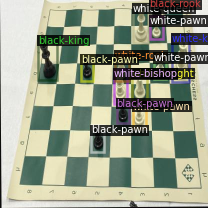

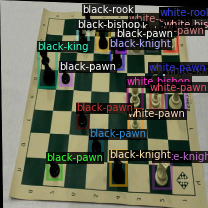

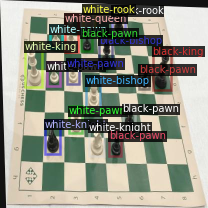

In [ ]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))# modify model here
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # modift model here
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.005


cfg.SOLVER.WARMUP_ITERS = 1800
cfg.SOLVER.MAX_ITER = 2000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1800, 2000)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14

cfg.TEST.EVAL_PERIOD = 500
cfg.TEST.DETECTIONS_PER_IMAGE = 64

In [ ]:
!CUDA_LAUNCH_BLOCKING=1
os.system('CUDA_LAUNCH_BLOCKING=1')

0

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/10 00:26:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:17, 23.6MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/10 00:26:33 d2.engine.train_loop]: Starting training from iteration 0
[03/10 00:28:09 d2.utils.events]:  eta: 2:39:07  iter: 19  total_loss: 3.719  loss_cls: 2.600  loss_box_reg: 0.910  loss_rpn_cls: 0.200  loss_rpn_loc: 0.059  time: 4.7896  data_time: 0.0312  lr: 0.000058  max_mem: 7604M
[03/10 00:29:45 d2.utils.events]:  eta: 2:43:39  iter: 39  total_loss: 2.318  loss_cls: 1.360  loss_box_reg: 0.912  loss_rpn_cls: 0.008  loss_rpn_loc: 0.038  time: 4.8100  data_time: 0.0253  lr: 0.000113  max_mem: 7604M
[03/10 00:31:18 d2.utils.events]:  eta: 2:30:08  iter: 59  total_loss: 1.939  loss_cls: 0.973  loss_box_reg: 0.913  loss_rpn_cls: 0.003  loss_rpn_loc: 0.033  time: 4.7482  data_time: 0.0208  lr: 0.000169  max_mem: 7604M
[03/10 00:32:55 d2.utils.events]:  eta: 2:40:07  iter: 79  total_loss: 1.762  loss_cls: 0.836  loss_box_reg: 0.901  loss_rpn_cls: 0.002  loss_rpn_loc: 0.030  time: 4.7773  data_time: 0.0254  lr: 0.000224  max_mem: 7604M
[03/10 00:34:31 d2.utils.events]:  eta: 2:38:2

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [03/10 03:08:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/10 03:08:45 d2.data.datasets.coco]: Loaded 29 images in COCO format from /content/dataset_chess/test/_annotations.coco.json
[03/10 03:08:45 d2.data.build]: Distribution of instances among all 14 categories:
|  category   | #instances   |   category   | #instances   |   category   | #instances   |
|:-----------:|:-------------|:------------:|:-------------|:------------:|:-------------|
|   pieces    | 0            |    bishop    | 0            | black-bishop | 21           |
| black-king  | 17           | black-knight | 25           |  black-pawn  | 86           |
| black-queen | 14           |  black-rook  | 26           | white-bishop | 25           |
| white-king  | 15           | white-knight | 25           |  white-pawn  | 88           |
| white-queen | 14           |  white-rook  | 20           |              |              |
|    total    

OrderedDict([('bbox',
              {'AP': 76.57942224407546,
               'AP-bishop': nan,
               'AP-black-bishop': 74.61111327851052,
               'AP-black-king': 83.65733422081703,
               'AP-black-knight': 75.66660516983377,
               'AP-black-pawn': 76.1963331857975,
               'AP-black-queen': 80.60396039603961,
               'AP-black-rook': 79.41736481340442,
               'AP-pieces': nan,
               'AP-white-bishop': 71.40995996398493,
               'AP-white-king': 76.1056105610561,
               'AP-white-knight': 81.06785866556581,
               'AP-white-pawn': 74.62034891657268,
               'AP-white-queen': 71.65795041042567,
               'AP-white-rook': 73.93862734689759,
               'AP50': 97.99726712282192,
               'AP75': 96.88881859780156,
               'APl': nan,
               'APm': 77.2903865225232,
               'APs': 75.75089277009543})])

In [ ]:
!python3 -V

Python 3.7.12


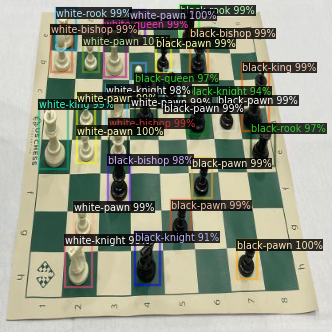

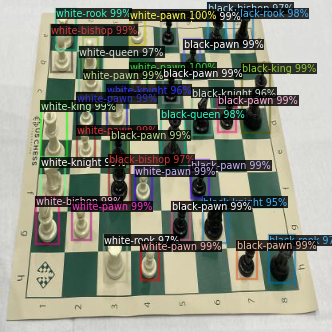

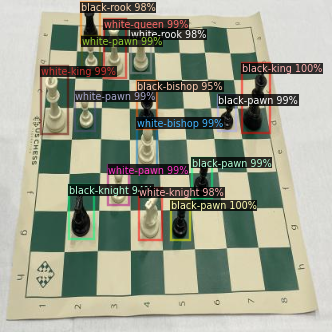

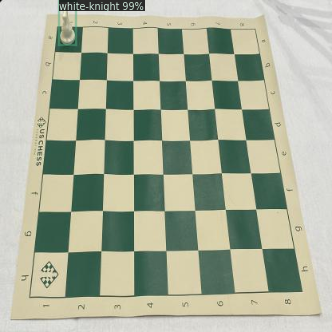

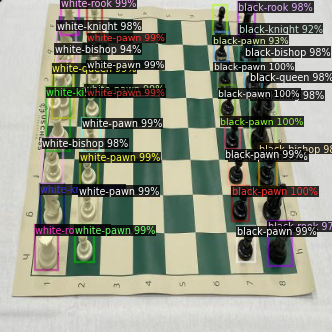

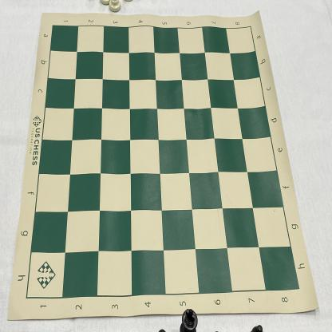

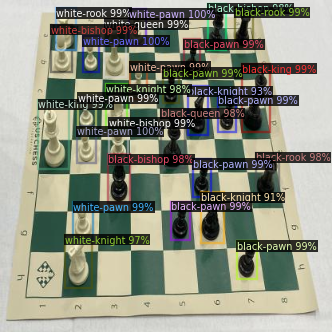

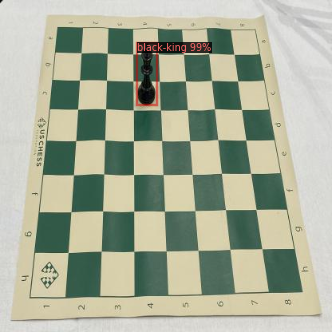

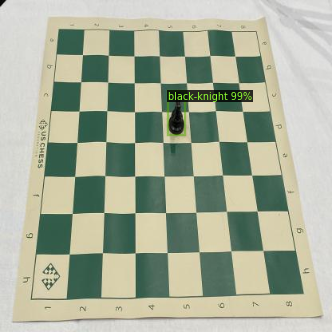

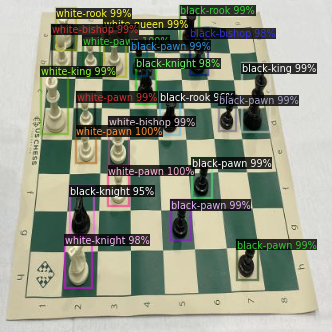

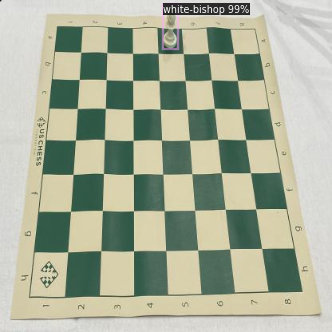

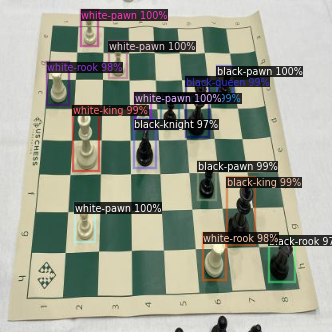

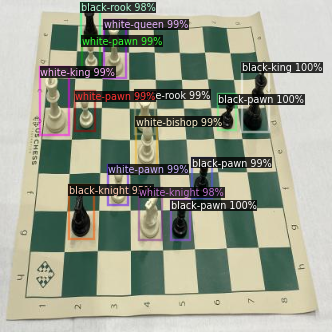

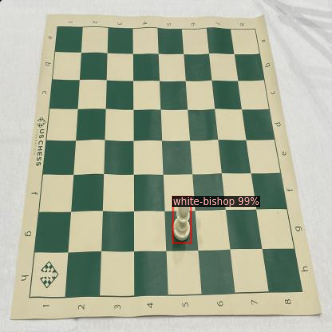

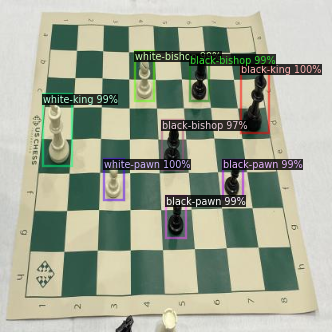

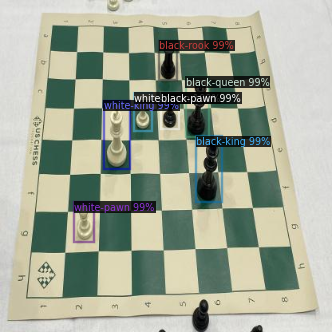

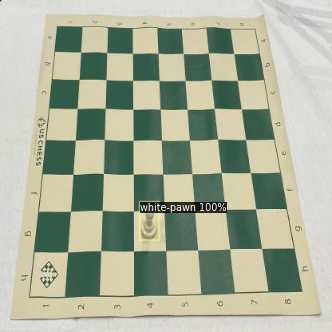

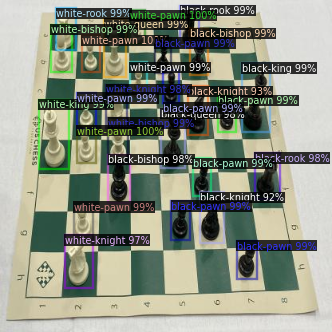

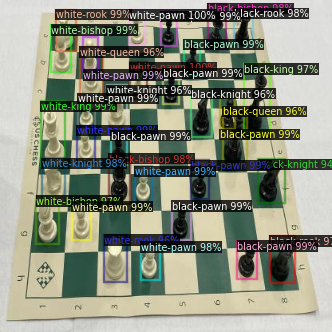

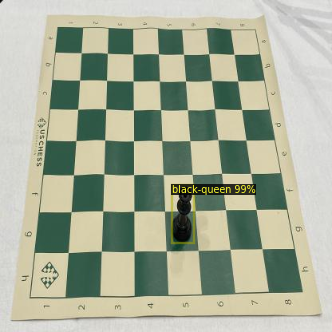

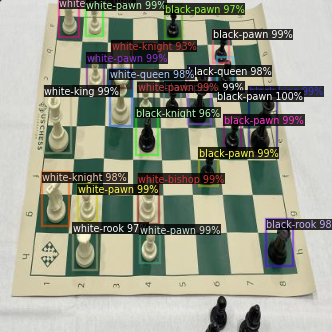

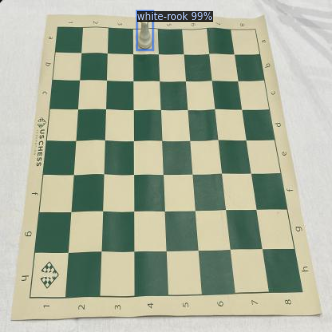

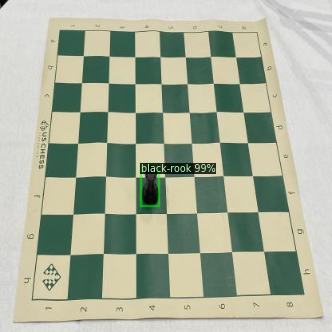

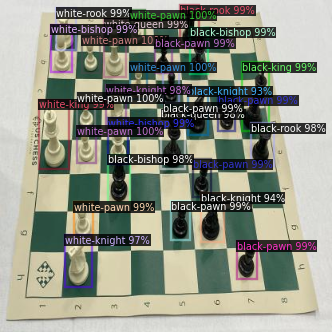

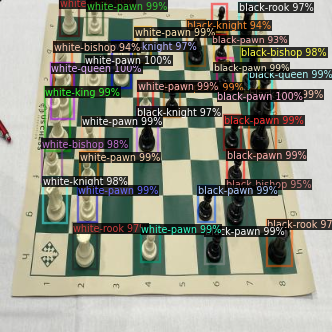

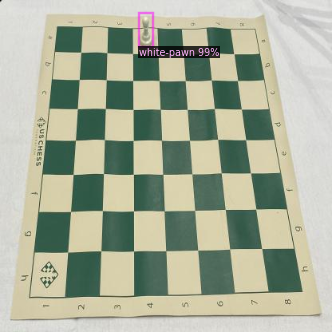

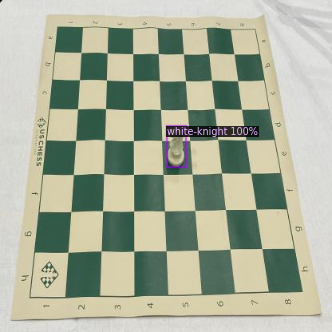

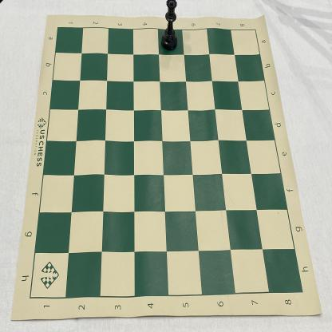

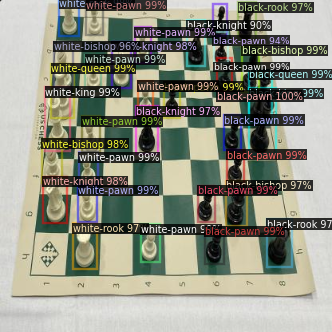

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/dataset_chess/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])